# Mini Project : Deep Learning (Machine Learning GDGoC Universitas Sriwijaya)

- Muhammad Aditya Bayhaqie
- Nabila Nurhusna Yap

Objective :

> Build a deep learning model to solve a problem either in image classification, text classification, or sequence prediction.

## CNN Model

### Library Preparation

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
from tqdm import tqdm


### Data Wrangling

#### Data Assessment

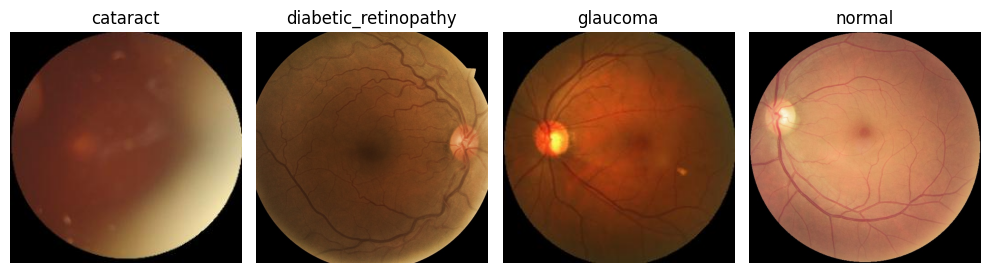

In [ ]:
def display_images_by_label(data_dir):
    labels = os.listdir(data_dir)
    labels.sort() # Sort labels for consistent display

    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes = axes.ravel()

    # Limit to the number of subplots available
    num_subplots = len(axes)
    for i, label in enumerate(labels[:num_subplots]):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            if image_files:
                # Select a random image from the label directory
                random_image_file = random.choice(image_files)
                img_path = os.path.join(label_path, random_image_file)
                img = mpimg.imread(img_path)

                axes[i].imshow(img)
                axes[i].set_title(label)
                axes[i].axis('off') # Hide axes

    # Hide any unused subplots if there are less than the number of subplots
    for j in range(len(labels), num_subplots):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming the unzipped data is in a directory named 'dataset'
# Adjust the path according to where your unzipped data is located
data_directory = '/kaggle/input/eye-diseases-classification/dataset'
display_images_by_label(data_directory)

#### Data Engineering

In [ ]:
# Define the original data directory and the new train/val directories
data_directory = '/kaggle/input/eye-diseases-classification/dataset'
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

# Create the train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get the list of labels (subdirectories)
labels = os.listdir(data_directory)

for label in labels:
    label_path = os.path.join(data_directory, label)
    if os.path.isdir(label_path):
        # Create subdirectories for the label in train and val
        train_label_dir = os.path.join(train_dir, label)
        val_label_dir = os.path.join(val_dir, label)
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(val_label_dir, exist_ok=True)

        # Get the list of image files in the current label directory
        image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(image_files) # Shuffle the images

        # Calculate the split point (90% for training)
        split_point = int(len(image_files) * 0.9)

        # Split the images into training and validation sets
        train_files = image_files[:split_point]
        val_files = image_files[split_point:]

        # Copy the files to the respective train and val directories
        for filename in train_files:
            src_path = os.path.join(label_path, filename)
            dest_path = os.path.join(train_label_dir, filename)
            shutil.copy(src_path, dest_path)

        for filename in val_files:
            src_path = os.path.join(label_path, filename)
            dest_path = os.path.join(val_label_dir, filename)
            shutil.copy(src_path, dest_path)

print("Data split into train and validation directories (9:1 ratio) successful.")
print(f"Train data saved in: {train_dir}")
print(f"Validation data saved in: {val_dir}")

Data split into train and validation directories (9:1 ratio) successful.
Train data saved in: /kaggle/working/train
Validation data saved in: /kaggle/working/val


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/working/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x.lower()])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model Development

In [ ]:
def train_model(model, criterion, optimizer, scheduler, writer= None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate modey
                writer.add_scalar('epoch', epoch)

            running_loss = 0.0
            running_corrects = 0


            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load Best model weight
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




## Finetuning


In [ ]:
from torch.utils.tensorboard import SummaryWriter

model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/densenet161_full')



2025-06-15 16:16:53.420552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750004213.646963      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750004213.716394      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current

## Model Train and Evaluate

In [ ]:
import os
if not os.path.exists('saved'):
    os.makedirs('saved')

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=20)

Epoch 0/19
----------


100%|██████████| 527/527 [01:42<00:00,  5.15it/s]


train Loss: 0.4695 Acc: 0.8217


100%|██████████| 144/144 [00:09<00:00, 14.54it/s]


val Loss: 0.1963 Acc: 0.9322

Epoch 1/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.86it/s]


train Loss: 0.2402 Acc: 0.9119


100%|██████████| 144/144 [00:09<00:00, 14.46it/s]


val Loss: 0.1051 Acc: 0.9652

Epoch 2/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.84it/s]


train Loss: 0.1822 Acc: 0.9376


100%|██████████| 144/144 [00:10<00:00, 14.40it/s]


val Loss: 0.1010 Acc: 0.9617

Epoch 3/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.86it/s]


train Loss: 0.1313 Acc: 0.9542


100%|██████████| 144/144 [00:09<00:00, 14.43it/s]


val Loss: 0.0354 Acc: 0.9922

Epoch 4/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0717 Acc: 0.9789


100%|██████████| 144/144 [00:09<00:00, 14.45it/s]


val Loss: 0.0296 Acc: 0.9922

Epoch 5/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0590 Acc: 0.9831


100%|██████████| 144/144 [00:10<00:00, 14.26it/s]


val Loss: 0.0267 Acc: 0.9939

Epoch 6/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0378 Acc: 0.9898


100%|██████████| 144/144 [00:10<00:00, 14.26it/s]


val Loss: 0.0081 Acc: 0.9991

Epoch 7/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0289 Acc: 0.9943


100%|██████████| 144/144 [00:10<00:00, 14.05it/s]


val Loss: 0.0056 Acc: 0.9991

Epoch 8/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.84it/s]


train Loss: 0.0271 Acc: 0.9934


100%|██████████| 144/144 [00:10<00:00, 14.25it/s]


val Loss: 0.0040 Acc: 1.0000

Epoch 9/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0232 Acc: 0.9948


100%|██████████| 144/144 [00:10<00:00, 14.31it/s]


val Loss: 0.0037 Acc: 1.0000

Epoch 10/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0205 Acc: 0.9967


100%|██████████| 144/144 [00:10<00:00, 14.34it/s]


val Loss: 0.0037 Acc: 1.0000

Epoch 11/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0158 Acc: 0.9981


100%|██████████| 144/144 [00:10<00:00, 14.20it/s]


val Loss: 0.0030 Acc: 1.0000

Epoch 12/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0155 Acc: 0.9981


100%|██████████| 144/144 [00:10<00:00, 14.19it/s]


val Loss: 0.0027 Acc: 1.0000

Epoch 13/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0166 Acc: 0.9981


100%|██████████| 144/144 [00:09<00:00, 14.45it/s]


val Loss: 0.0026 Acc: 1.0000

Epoch 14/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.86it/s]


train Loss: 0.0144 Acc: 0.9983


100%|██████████| 144/144 [00:10<00:00, 14.27it/s]


val Loss: 0.0034 Acc: 1.0000

Epoch 15/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0144 Acc: 0.9974


100%|██████████| 144/144 [00:10<00:00, 14.32it/s]


val Loss: 0.0028 Acc: 1.0000

Epoch 16/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.84it/s]


train Loss: 0.0181 Acc: 0.9967


100%|██████████| 144/144 [00:10<00:00, 14.32it/s]


val Loss: 0.0026 Acc: 1.0000

Epoch 17/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0173 Acc: 0.9972


100%|██████████| 144/144 [00:10<00:00, 14.16it/s]


val Loss: 0.0025 Acc: 1.0000

Epoch 18/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0144 Acc: 0.9976


100%|██████████| 144/144 [00:10<00:00, 14.26it/s]


val Loss: 0.0024 Acc: 1.0000

Epoch 19/19
----------


100%|██████████| 527/527 [01:48<00:00,  4.85it/s]


train Loss: 0.0167 Acc: 0.9967


100%|██████████| 144/144 [00:09<00:00, 14.43it/s]


val Loss: 0.0025 Acc: 1.0000

Training complete in 39m 28s
Best val Acc: 1.000000


### Model Evaluation

In [ ]:
torch.save(model_ft.state_dict(), '/kaggle/working/saved/densenet.pt')

print(os.listdir('/kaggle/working/saved'))


['densenet.pt']


In [ ]:
model_path = '/kaggle/working/saved/densenet.pt'
model_ft.load_state_dict(torch.load('/kaggle/working/saved/densenet.pt'))
model_ft.eval()

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=1, shuffle=True, num_workers=4
    )
    for x in ['train', 'val']
}


In [ ]:
import imageio

classes = {
    0: 'Cataract',
    1: 'Diabetic Retinopathy',
    2: 'Glaucoma',
    3: 'Normal'
}

# Counters
total = 0
correct = 0

# Evaluate on the validation set
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    total += 1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct += 1
    else:
        # Save misclassified images
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1, 2, 0))
        imageio.imwrite(f"misclassified_{total}.jpg", img)

        print(
            f"[{total}] Original class: {classes[int(labels.data[0].cpu().numpy())]} | "
            f"Predicted class: {classes[int(preds.data[0].cpu().numpy())]}"
        )

print(f"\nCorrect: {correct} / {total} | Accuracy: {correct / total:.2%}")

100%|██████████| 1150/1150 [00:35<00:00, 32.16it/s]


Correct: 1150 / 1150 | Accuracy: 100.00%


## Pre-Build Model

In [ ]:
!pip install lazypredict

### Library Preparation

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from PIL import Image # Import Pillow for image processing
import os
import torch.nn as nn # Import the nn module
from torchvision import models

### LazyPredict Model Prediction

In [ ]:
def load_image_data(data_dir):
    """Loads image file paths and labels from a directory structure."""
    image_paths = []
    labels = []
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                if image_file.endswith(('jpg', 'jpeg', 'png')):
                    image_paths.append(os.path.join(label_path, image_file))
                    labels.append(label)
    return image_paths, labels

# Load data
train_image_paths, train_labels = load_image_data(train_dir)
val_image_paths, val_labels = load_image_data(val_dir)

# Combine train and validation for LazyPredict
all_image_paths = train_image_paths + val_image_paths
all_labels = train_labels + val_labels

# Create a DataFrame
data = {'image_path': all_image_paths, 'label': all_labels}
df = pd.DataFrame(data)

# Convert labels to numerical format
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data for LazyPredict (features X, target y)
X = df['image_path']
y = df['label_encoded']

In [ ]:
def load_and_flatten_image(image_path, target_size=(32, 32)):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        return np.array(img).flatten()
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros(target_size[0] * target_size[1] * 3) # Return zero array on error

# Limit the number of images for a quicker demo with dummy features
subset_size = 200 # Reduce this if hitting memory limits
subset_df = df.sample(n=min(subset_size, len(df)), random_state=42).reset_index(drop=True)

# Extract dummy features (flattened pixel data)
# This will still require significant memory for large images or many images
print(f"Loading and processing {len(subset_df)} images for LazyPredict demo...")
X_subset_features = np.array([load_and_flatten_image(p) for p in tqdm(subset_df['image_path'])])
y_subset = subset_df['label_encoded']

# Split the subset data for LazyPredict
X_train_lp, X_test_lp, y_train_lp, y_test_lp = train_test_split(X_subset_features, y_subset, test_size=0.2, random_state=42, stratify=y_subset)

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and predict
print("Running LazyPredict Classifier...")
models_lp, predictions_lp = clf.fit(X_train_lp, X_test_lp, y_train_lp, y_test_lp)

print("\nLazyPredict Results (based on dummy features from a subset of images):")
models_lp

### Data Wrangling

#### Data Collection

In [ ]:
def load_and_preprocess_images(data_dir, target_size=(100, 100)):
    images = []
    labels = []
    labels_list = os.listdir(data_dir)
    for label in labels_list:
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size)
                    images.append(np.array(img))
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

#### Data Assessment

In [ ]:
data_directory = '/kaggle/input/eye-diseases-classification/dataset'
images, labels = load_and_preprocess_images(data_directory)

#### Data Engineering

In [ ]:
# Flatten the images
n_samples, height, width, channels = images.shape
X = images.reshape(n_samples, height * width * channels)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loading and preprocessing complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

### Model Development

In [ ]:
# We are only loading the model structure and weights, not the training pipeline
model = models.resnet50(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Modify the final classification layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(label_encoder.classes_))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # Optimize only the classifier parameters

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Convert the numpy arrays to PyTorch tensors and create DataLoader
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

# Reshape the input tensors to be in the format (batch_size, channels, height, width)
X_train_tensor = X_train_tensor.view(X_train_tensor.size(0), 3, 100, 100)
X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), 3, 100, 100)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete.")

### Model Evaluation

In [ ]:
# Set the model to evaluation mode
model.eval()

running_corrects = 0
total_samples = 0

# Iterate over the test data
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        total_samples += labels.size(0)
        running_corrects += torch.sum(preds == labels.data)

# Calculate accuracy
accuracy = running_corrects.double() / total_samples

print(f"Test Accuracy: {accuracy:.4f}")